In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy.linalg import det

data1 = loadmat('lab2_1.mat')
data2 = loadmat('lab2_2.mat')
data3 = loadmat('lab2_3.mat')

al = data2['al']
bl = data2['bl']
cl = data2['cl']

In [2]:
mu_hat_al = np.sum(al, axis=0) / al.size
sigma_hat_al = (al - mu_hat_al).T@(al - mu_hat_al) / al.size
sigma_hat_al

array([[15939.4954,  4896.193 ],
       [ 4896.193 ,  3806.73  ]])

In [3]:
mu_hat_bl = np.sum(bl, axis=0) / bl.size
sigma_hat_bl = (bl - mu_hat_bl).T@(bl - mu_hat_bl) / bl.size
sigma_hat_bl

array([[12287.6104 ,  8754.3912 ],
       [ 8754.3912 ,  7963.03985]])

In [4]:
mu_hat_cl = np.sum(cl, axis=0) / cl.size
sigma_hat_cl = (cl - mu_hat_cl).T@(cl - mu_hat_cl) / cl.size
sigma_hat_cl

array([[ 3142.0590625,  4523.5855625],
       [ 4523.5855625, 15863.6516625]])

In [5]:
class Cluster:
    def __init__(self, x, mu, sigma, name=''):
        self.mu = mu
        self.sigma = sigma
        self.x = x
        self.N = x.size
        self.name = name

In [6]:
al_cluster = Cluster(al, mu_hat_al, sigma_hat_al, name = 'al')
bl_cluster = Cluster(bl, mu_hat_bl, sigma_hat_bl, name = 'bl')
cl_cluster = Cluster(cl, mu_hat_cl, sigma_hat_cl, name = 'cl')
classes = [al_cluster, bl_cluster, cl_cluster]

In [7]:
def ml_classifier(x, classes):
    """
    Classify a point (x, y) into classes using ML
    
    """
    x = np.array(x).reshape(2, 1)
    likelihoods = []
    for c in classes:
        likelihood = np.exp(-0.5 * (x - c.mu.reshape(2,1)).T @ np.linalg.inv(c.sigma)@ (x - c.mu.reshape(2,1))) / (2 * np.pi * np.sqrt(det(c.sigma)))
        likelihoods.append(likelihood)
    idx = np.argmax(likelihoods)
    return idx

In [8]:
def ml_classifier_array(x, classes):
    """
    Classifies array, assigning each point a class based on Maximum likelihood
    """
    likelihoods = []
    for c in classes:
        mean = (x.reshape(x.shape[0], 1, 2) - c.mu.reshape(1, 2)) 
        sigma = np.linalg.inv(c.sigma)
        res =  mean @ sigma.T
        res = res @ mean.reshape(x.shape[0], 2, 1)
        likelihood = np.exp(-0.5 * res.flatten()) / (2 * np.pi * np.sqrt(det(c.sigma)))
        likelihoods.append(likelihood)
    
    idx = np.argmax(np.array(likelihoods), axis=0)
    return idx


In [62]:
ymin, ymax, xmin, xmax = 0, 500, 0, 500
step = 1
count = int((xmax-xmin+1)/step)
x = np.linspace(xmin, xmax, count)
y = np.linspace(ymin, ymax, count)
x_coords, y_coords = np.meshgrid(x, y, indexing='ij')
classified_array = np.zeros_like(x_coords)

In [70]:
# Make grid
xlims = (xmin, xmax)
ylims = (ymin, ymax)
dx = dy = 1

xx, yy = np.meshgrid(np.arange(*xlims, dx), np.arange(*ylims, dy))

# Create vectors to feed to classifier
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1, r2))


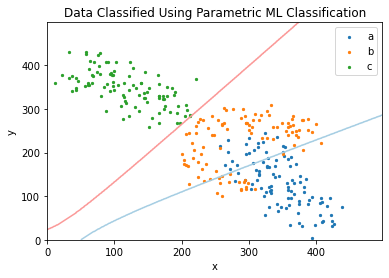

In [71]:
y_pred = ml_classifier_array(grid, classes)
zz = np.array(y_pred).reshape(xx.shape)
plt.contour(xx, yy, zz, levels=list(range(4)), cmap='Paired')

plt.scatter(al_cluster.x[:, 0], al_cluster.x[:, 1], label='a', s=5)
plt.scatter(bl_cluster.x[:, 0], bl_cluster.x[:, 1], label='b', s=5)
plt.scatter(cl_cluster.x[:, 0], cl_cluster.x[:, 1], label='c', s=5)

plt.legend()
plt.title("Data Classified Using Parametric ML Classification")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [12]:
# for i in range(count):
#     for j in range(count):
#         for k in range(count):
#             x = np.array([x_coords[i][j], y_coords[i][j]]).reshape(2,1)
#             classified = ml_classifier(x, classes)
#             classified_array[i, j] = classified

In [29]:
def plot_classified_data(classified_data, classes):
    plt.contour(x_coords, y_coords, classified_data, cmap='Paired', levels=[0, 1, 2])

    # Plot points
    # Reset colours
    plt.gca().set_prop_cycle(None)
    for c in classes:
        plt.scatter(c.x[:, 0], c.x[:, 1], cmap='Paired', label=f'{c.name}')

    # zz = np.array(classified_data).reshape(x_coords.shape)
    # plt.contour(x_coords, y_coords, zz, levels=list(range(len(classes))), linewidths=3, zorder=3)
    plt.legend()
    plt.title("Data Classified Using Non-Parametric Parzen Window Estimation")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()

In [56]:
from parzen import parzen
from scipy.signal.windows import gaussian

kernel = gaussian(151, std=20)

res = [1, 0, 0, 500, 500]
p_al, x, y = parzen(al, res, kernel)
p_bl, x, y = parzen(bl, res, kernel)
p_cl, x, y = parzen(cl, res, kernel)



In [68]:
classified_array_parzen = np.zeros_like(x_coords)
for i in range(count):
    for j in range(count):
        probabilities = []
        for p in [p_al, p_bl, p_cl]:
            probability = p[i][j]
            probabilities.append(probability)
        classified = np.argmax(probabilities)
        classified_array_parzen[j, i] = classified
        
        

In [64]:
for i in range(500):
    classified_array_parzen[i]

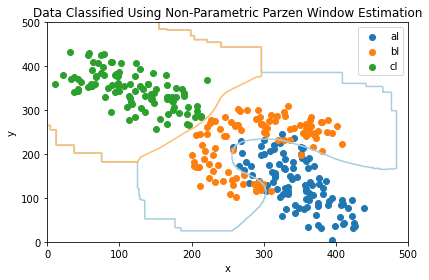

In [69]:
plot_classified_data(classified_array_parzen, classes)